In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import pandas as pd

In [2]:
import spacy

In [6]:
from cooc import *
#rom glove_template import *
from pickle_vocab import *
from pre_processing import pre_process

[autoreload of pre_processing failed: Traceback (most recent call last):
  File "C:\Users\Pont Naomie\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Pont Naomie\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Pont Naomie\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Pont Naomie\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Users\Pont Naomie\project2-ML\project2-ML\pre_processing.py", line 274, in <module>
    "execution_count": null,
NameError: name 'null' is not defined
]


ImportError: cannot import name 'pre_process' from 'pre_processing' (C:\Users\Pont Naomie\project2-ML\project2-ML\pre_processing.py)

In [ ]:
with open('twitter-datasets/train_pos.txt') as f:
    pos = f.readlines()

In [ ]:
with open('twitter-datasets/train_neg.txt') as f:
    neg = f.readlines()

In [ ]:
train=pos+neg

In [6]:
train_target=[':)']*len(pos)+[':(']*len(neg)

In [7]:
full_train={'data':train,
           'target':train_target}
full_train=pd.DataFrame(full_train)
full_train.sample(5)

,data,target
197319,when this day come back #superjunior <url>\n,:(
72052,<user> glad to hear you're on the mend i'm goo...,:)
16522,<user> thanx\n,:)
183115,( ' ' ) ( ' ' ) rt <user> i hate mine ! ! i've...,:(
143248,"<user> heeey my angel , my name is monique and...",:(


## Data pre-processing

In [ ]:
full_train=pre_process(full_train)
test_data=pre_process(test_data)

In [7]:
##to be done on data with features

def preprocess(data_X) :
    """
    Function:
            for each line in data X, there may be different sizes of features, so normalization is needed for the 
            further methods
    """
    
    x=data_X.copy()
    x=np.array(x)
    

    if x.shape[0] > 1 : 
        x = np.array([ StandardScaler().fit_transform(line) for line in x ])
    else :
        x = StandardScaler().fit_transform(x)
   
    return x

# Data exploration

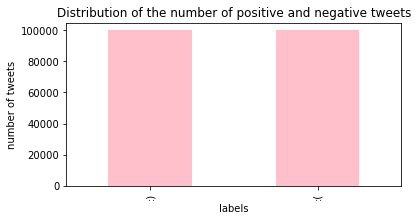

In [8]:
full_train['target'].value_counts().plot.bar(color = 'pink', figsize = (6, 3))
plt.title("Distribution of the number of positive and negative tweets")
plt.ylabel("number of tweets")
plt.xlabel("labels")
plt.show()

The number of tweets per label (positive or negative) is the same. 

In [9]:
full_train.groupby('target').describe()

data                                                                
         count unique                                                top  freq
target                                                                        
:(      100000  91088  i just wrote this ( tell me what you think <ur...   335
:)      100000  90233  i love our fans ! there all so beautiful ! x <...  1536

As already stated above, there is the same number of positive and negative tweets (100'000). In both sets, we have some duplicated tweets as the number of unique tweets for **:(** and for **:)** labels is inferior to 100'000 and it seems that there are more duplicates for the **:)** label. Moreover, the two tweets (one per label) that are the most frequent, have frequency of 335 for **:(** and 1536 for **:)**.  

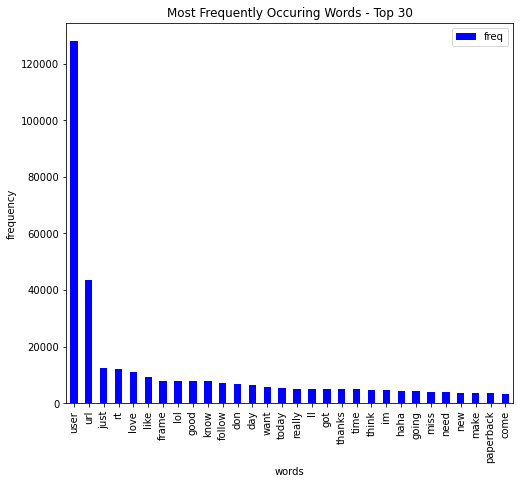

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

##Let's have a look at the words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(full_train.data)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(8, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")
plt.xlabel('words')
plt.ylabel('frequency')
plt.show()

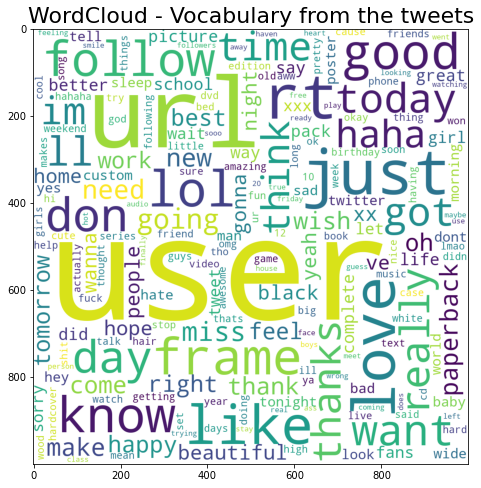

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from the tweets", fontsize = 22)
plt.show()

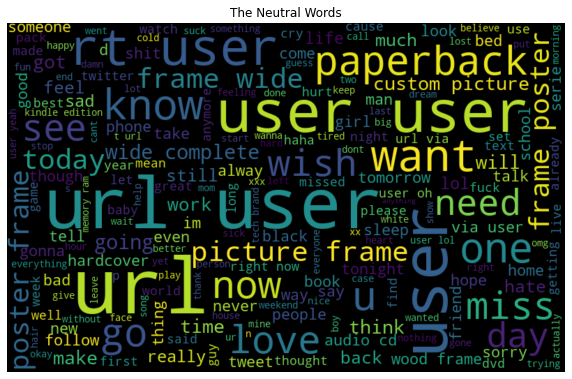

In [17]:

normal_words =' '.join([text for text in full_train['data'][full_train['target'] == ':(']])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

#### Split the data

In [132]:
from sklearn.model_selection import train_test_split

train , test=train_test_split(full_train)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

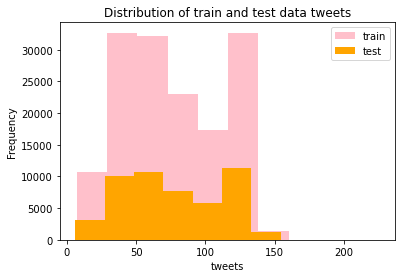

In [19]:
length_train = train['data'].str.len().plot.hist( color = 'pink', figsize = (6, 4), label="train")
length_test = test['data'].str.len().plot.hist(test, color = 'orange', figsize = (6, 4), label="test")
plt.legend(loc='upper right')
plt.xlabel("tweets")
plt.title("Distribution of train and test data tweets")
plt.show()

### Bayes Classifier

In [20]:
# Extracting features from text files

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

(150000, 85105)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(150000, 85105)

In [22]:
from sklearn.naive_bayes import MultinomialNB

# Training Naive Bayes (NB) classifier on training data.
clf = MultinomialNB().fit(X_train_tfidf, train.target)

In [23]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(train.data, train.target)

In [24]:
predicted = text_clf.predict(test.data)
np.mean(predicted == test.target)

0.76696

### SVM

In [25]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.data, train.target)
predicted_svm = text_clf_svm.predict(test.data)
np.mean(predicted_svm == test.target)

0.81146

### Trying models Alex (doesn't work because of float)


In [26]:
maxs = []
for elem in train:
    maxs.append(len(elem.split(" ")))
max_ = max(maxs)

In [27]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train.data, train.target, test_size = 0.25, random_state = 42)
#train.data, test.data, train.target ...

In [99]:
def create_sequences(max_, train, test):
    # fit train words to tokenizer
    tokenizer.fit_on_texts(train)
    # get words and their indexes
    word_index = tokenizer.word_index
    # number of words
    nb_word = len(word_index)
    print(nb_word)
    # transform text to sequence
    X_sequences = tokenizer.texts_to_sequences(train)
    test_sequences = tokenizer.texts_to_sequences(test)
    
    # Pad sequences
    X_sequences = sequence.pad_sequences(X_sequences, maxlen=30,padding='pre')
    test_sequences = sequence.pad_sequences(test_sequences, maxlen=30,padding='pre')

    # create y, first pos then neg
    train_size = len(train)
    y = np.array(int(train_size/2) * [1] + int(train_size/2) * [0])

    # create indices 
    indices = np.arange(X_sequences.shape[0])
    np.random.shuffle(indices)
    X_sequences = X_sequences[indices]
    y = y[indices]
    print("Sequences created!") 
    return X_sequences, test_sequences, y, nb_word, word_index


X_sequences, test_sequences, y, nb_word, word_index = create_sequences(max_,train, test)

NameError: name 'tokenizer' is not defined

In [21]:
def create_glove_matrix(word_embedding, train, nb_word):
    '''
    This method creates an embedding matrix from a dict passed in argument
    '''
    X_splitted = [x.split() for x in train]

    glove_matrix = np.zeros((nb_word + 1, 200))
    for word, i in word_index.items():
        embedding_vector = word_embedding.get(word.encode())
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            glove_matrix[i] = embedding_vector
    print('Matrix created')
    
    return glove_matrix

In [71]:
glove_matrix = create_glove_matrix(glove_template.row, train ,nb_word)

NameError: name 'glove_template' is not defined

In [63]:
# tokenizing the words present in the training set
tokenized_tweet = train['data'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['data']), epochs=20)

(34440803, 47185960)

In [28]:
#Other way of splitting
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train.data, train.target, test_size = 0.25, random_state = 42)
#train.data, test.data, train.target, test.target
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(112500,)
(37500,)
(112500,)
(37500,)


In [29]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(train.data)
x_valid = sc.transform(test.data)

ValueError: could not convert string to float: 'leg based library table with curbing ( 60 " wx30 " d 10 " - high curbing runs along the entire length inside the edgeb ... <url>\n'

In [82]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train.data, train.target)

y_pred = model.predict(test.data)

print("Training Accuracy :", model.score(train.data, train.target))
print("Validation Accuracy :", model.score(test.data, test.target))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(test.target, y_pred))

# confusion matrix
cm = confusion_matrix(test.target, y_pred)
print(cm)

ValueError: could not convert string to float: 'rt if you have won us finals so far this season .\n'

In [83]:
Logistic Regression

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train.data, train.target)

y_pred = model.predict(test.data)

print("Training Accuracy :", model.score(train.data, train.target))
print("Validation Accuracy :", model.score(test.data, test.target))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(test.target, y_pred))

# confusion matrix
cm = confusion_matrix(test.target, y_pred)
print(cm)

ValueError: could not convert string to float: 'rt if you have won us finals so far this season .\n'

## Trying something with the file generated from glove_template

In [86]:
#loading the data
embedding = np.load('embeddings.npy')
embedding

array([[ 0.22640361, -0.40024342,  0.14873088, ..., -0.34243433,
         0.24890988,  0.01761889],
       [ 0.28307899, -0.53898438,  0.17432014, ..., -0.46657558,
         0.26930201,  0.03843433],
       [ 0.36069745, -0.61174519,  0.20528002, ..., -0.51441128,
         0.29707903,  0.01627219],
       ...,
       [ 1.32456955, -1.10948019,  0.08538186, ..., -0.0783017 ,
        -0.61777957, -0.41361194],
       [ 1.28636033,  0.55541084, -1.43948695, ..., -0.11769803,
        -0.39038506, -1.718321  ],
       [ 0.34752891,  0.58156755,  0.4432093 , ...,  0.01954502,
        -1.43372399,  1.51159475]])

In [87]:
#Associate embedding with vocab words but we should do a cleaning of the vocab first such as remove word "user"
#Remove punctuations...

vocab = pickle.load(open('vocab.pkl', "rb")) #this file was generated by executing vocab.sh
word_embedding = {}
for key in vocab.keys():
    word_embedding[key] = embedding[vocab.get(key)] # keys in this dict are not encoded 

In [88]:
word_embedding_ = pd.DataFrame(word_embedding).T
word_embedding_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
<user>,0.226404,-0.400243,0.148731,-0.309545,0.437378,0.213579,0.086634,0.117222,-0.031624,-0.189807,0.075544,0.262635,0.093118,-0.181715,0.127778,0.143108,-0.642995,-0.342434,0.248910,0.017619
!,0.283079,-0.538984,0.174320,-0.456451,0.557047,0.291655,0.065464,0.143789,-0.083148,-0.269861,0.076847,0.346635,0.097444,-0.220878,0.175739,0.183959,-0.826266,-0.466576,0.269302,0.038434
i,0.360697,-0.611745,0.205280,-0.462878,0.626769,0.368973,0.082274,0.210788,-0.066077,-0.311920,0.121792,0.395722,0.131281,-0.296751,0.196175,0.197906,-0.918471,-0.514411,0.297079,0.016272
the,0.193769,-0.340248,0.111929,-0.281421,0.371043,0.209030,0.065292,0.102964,-0.034729,-0.163570,0.058555,0.210547,0.050456,-0.137820,0.070799,0.158073,-0.526475,-0.278441,0.174314,0.025058
.,0.260140,-0.445702,0.156586,-0.358412,0.448107,0.245286,0.070963,0.124010,-0.047129,-0.198813,0.029821,0.298787,0.113753,-0.209915,0.115067,0.179827,-0.683049,-0.371635,0.178485,0.028656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#24,-1.228059,0.386174,0.149373,-1.300654,1.220777,-1.103717,0.627890,0.293057,0.890352,-0.434923,-0.350357,1.142025,-1.026087,-0.995815,0.453091,0.368598,-0.890545,-0.083759,-0.491193,1.292168
#20,-0.339267,-0.344205,2.727286,-1.271266,0.235092,-1.506849,-0.177515,-1.504133,-0.127304,-0.037728,-0.189938,1.832045,-0.894836,-0.854460,-1.425314,-1.885691,-1.521108,-0.824040,1.220593,0.119998
#1dsongconcept,1.324570,-1.109480,0.085382,-0.669933,0.333532,-0.025574,1.347987,0.100968,-2.557069,-0.539510,-0.034116,0.356405,1.317865,1.454039,0.985475,-0.138019,0.478292,-0.078302,-0.617780,-0.413612
#18,1.286360,0.555411,-1.439487,-0.726298,0.561588,1.529754,-0.763835,0.810664,-0.148597,-0.092443,0.419743,0.822190,0.784177,1.833801,-1.068968,0.242448,0.304482,-0.117698,-0.390385,-1.718321


In [89]:
def average_word_vectors(tweets ,word_embedding):
    
    error = 0
    avg_word_vectors = np.zeros((len(tweets), word_embedding.shape[1] ))
    for i, tweet in enumerate(tweets):
        
        split_tweet = tweet.split()
        nb_words = 0
        
        for word in split_tweet:
            try:
                avg_word_vectors[i] += word_embedding.loc[word].to_numpy()
                nb_words += 1

            except KeyError: 
                continue
        if (nb_words != 0):
            avg_word_vectors[i] /= nb_words
        
    return avg_word_vectors

In [90]:
avg_word_vectors = average_word_vectors(train.data ,word_embedding_)
avg_word_vectors_df = pd.DataFrame(avg_word_vectors)
avg_word_vectors_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.334727,-0.389052,0.258885,-0.436901,0.398172,0.240448,0.217607,0.097017,-0.004990,-0.084625,0.041340,0.137577,0.234235,-0.126867,0.161179,0.130632,-0.640609,-0.352011,0.352508,0.114536
1,0.253545,-0.322083,0.122027,-0.477787,0.633793,0.462577,0.286598,0.184167,-0.015829,-0.418253,-0.031388,0.385276,0.086990,-0.138010,0.142607,0.254616,-0.769044,-0.249547,0.220819,0.045726
2,0.211193,-0.377544,0.131094,-0.479212,0.623364,0.318001,0.243393,0.366974,-0.121412,-0.107740,0.003156,0.369005,0.077222,-0.136456,0.109561,0.102509,-0.663665,-0.264595,0.264221,0.046477
3,0.302177,-0.472644,0.275390,-0.481437,0.513083,0.327909,0.191156,0.200191,-0.139684,-0.226199,0.075771,0.405032,0.154839,-0.287969,0.239375,0.247583,-0.945351,-0.557228,0.241654,0.026749
4,0.328707,-0.623066,0.189293,-0.508590,0.678446,0.342316,0.036729,0.194127,-0.082022,-0.286508,0.061434,0.445450,0.095606,-0.314617,0.150854,0.297054,-0.929639,-0.519282,0.375249,0.009493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0.283732,-0.581281,0.245771,-0.532774,0.531537,0.348454,0.079517,0.212449,-0.130556,-0.200298,-0.025640,0.349834,0.171173,-0.230798,0.148080,0.159805,-0.756512,-0.509267,0.295804,0.042764
149996,0.412055,-0.205294,0.233578,-0.518238,0.571992,0.209295,-0.013177,0.121609,-0.228465,-0.048240,-0.127138,0.310255,-0.194480,0.005583,0.051573,0.300406,-0.840887,-0.080810,0.181049,0.101734
149997,0.369714,-0.328225,0.284220,-0.380765,0.676195,0.247564,0.231858,0.217285,-0.081158,-0.225459,0.044305,0.248641,0.072073,-0.301574,0.178655,0.130744,-0.978125,-0.508792,0.320544,0.182162
149998,0.251009,-0.593227,0.095302,-0.572382,0.591592,0.446676,0.103375,0.163552,-0.143684,-0.346777,0.183854,0.330985,0.122852,-0.314819,0.225606,0.199284,-0.970377,-0.424365,0.351120,-0.122533


In [141]:
#Associate tweets with the average word vectors of each tweet
sample_train_word_vectors= train.join(avg_word_vectors_df)
sample_train_word_vectors

,index,data,target,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,194504,ugh . think my ulcer is starting up from all t...,:(,0.334727,-0.389052,0.258885,-0.436901,0.398172,0.240448,0.217607,...,0.041340,0.137577,0.234235,-0.126867,0.161179,0.130632,-0.640609,-0.352011,0.352508,0.114536
1,150194,disney tangled ( video game disney's tangled :...,:(,0.253545,-0.322083,0.122027,-0.477787,0.633793,0.462577,0.286598,...,-0.031388,0.385276,0.086990,-0.138010,0.142607,0.254616,-0.769044,-0.249547,0.220819,0.045726
2,170923,omg wish i looked like tumblr girls there stun...,:(,0.211193,-0.377544,0.131094,-0.479212,0.623364,0.318001,0.243393,...,0.003156,0.369005,0.077222,-0.136456,0.109561,0.102509,-0.663665,-0.264595,0.264221,0.046477
3,85685,<user> haha i'm excited for dinner tonight its...,:),0.302177,-0.472644,0.275390,-0.481437,0.513083,0.327909,0.191156,...,0.075771,0.405032,0.154839,-0.287969,0.239375,0.247583,-0.945351,-0.557228,0.241654,0.026749
4,110318,ftp relaunch tournaments ( cont welcome back t...,:(,0.328707,-0.623066,0.189293,-0.508590,0.678446,0.342316,0.036729,...,0.061434,0.445450,0.095606,-0.314617,0.150854,0.297054,-0.929639,-0.519282,0.375249,0.009493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,13691,"<user> don't do gov , we don't have her me\n",:),0.283732,-0.581281,0.245771,-0.532774,0.531537,0.348454,0.079517,...,-0.025640,0.349834,0.171173,-0.230798,0.148080,0.159805,-0.756512,-0.509267,0.295804,0.042764
149996,143101,its not my fault tell me how you feel\n,:(,0.412055,-0.205294,0.233578,-0.518238,0.571992,0.209295,-0.013177,...,-0.127138,0.310255,-0.194480,0.005583,0.051573,0.300406,-0.840887,-0.080810,0.181049,0.101734
149997,194689,greenes 4 ft . wooden garden stakes ( 12 pack ...,:(,0.369714,-0.328225,0.284220,-0.380765,0.676195,0.247564,0.231858,...,0.044305,0.248641,0.072073,-0.301574,0.178655,0.130744,-0.978125,-0.508792,0.320544,0.182162
149998,100576,everyone talking about #world's2012 makes me w...,:(,0.251009,-0.593227,0.095302,-0.572382,0.591592,0.446676,0.103375,...,0.183854,0.330985,0.122852,-0.314819,0.225606,0.199284,-0.970377,-0.424365,0.351120,-0.122533


In [142]:
#sample_train_word_vectors = pd.concat([train, avg_word_vectors_df],axis=1)

In [152]:
X_train = sample_train_word_vectors.drop(columns=["data","target","index"])

In [155]:
Y_train = sample_train_word_vectors.target


array([':(', ':(', ':(', ..., ':(', ':(', ':('], dtype=object)

In [156]:
avg_word_vectors_test_df = pd.DataFrame(average_word_vectors(test.data ,word_embedding_))

KeyboardInterrupt: 

In [157]:
sample_test_word_vectors=test.join(avg_word_vectors_test_df)
X_test = sample_test_word_vectors.drop(columns=["data","target", "index"])
Y_test = sample_test_word_vectors.target

### Training models with glove 

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [161]:
linear_reg = LogisticRegression()
linear_reg = linear_reg.fit(X_train, Y_train)
y_pred = linear_reg.predict(avg_word_vectors_test_df)
print("Training Accuracy :", model.score(X_train, Y_train))
print("Validation Accuracy :", model.score(X_test, Y_test))

Training Accuracy : 0.5046933333333333
Validation Accuracy : 0.47056


In [160]:
#Logistic Regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

print("Training Accuracy :", model.score(X_train, Y_train))
print("Validation Accuracy :", model.score(X_test, Y_test))


# confusion matrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Accuracy : 0.5046933333333333
Validation Accuracy : 0.47056
[[14169 10733]
 [15739  9359]]


In [163]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=1000, random_state=42))])

text_clf_svm = text_clf_svm.fit(X_train, Y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == Y_test)

AttributeError: 'int' object has no attribute 'lower'

### Create submission

In [69]:
with open('twitter-datasets/test_data.txt') as f:
    real_test = f.readlines()

In [70]:
import re
ids=[]   
for i in range (len(real_test)):
    text=real_test[i]
    found=re.findall('\d+', text )
    ids.append(found[0])

In [71]:
import csv

def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in .csv format for submission to Kaggle or AIcrowd
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            if (r2==':)'):
                r2=1
                writer.writerow({'Id':int(r1),'Prediction':r2})
            if(r2==':('):
                r2=-1
                writer.writerow({'Id':int(r1),'Prediction':r2})

In [ ]:
OUTPUT_PATH = 'sample_submission.csv' # TODO: fill in desired name of output file for submission
#weights, loss=ridge_regression(y_train, x_train, best_lambda)
#y_pred = text_clf_svm.predict(real_test)
create_csv_submission(ids, y_pred, OUTPUT_PATH)